In [5]:
import os
import argparse
import math
import glob
import random
import itertools
import datetime
import time
import sys
import warnings
import scipy.io
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch import Tensor

import torch.autograd as autograd 
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.backends import cudnn

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Compose, Resize, ToTensor

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt


from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from utils import GradCAM, show_cam_on_image

cudnn.benchmark = False
cudnn.deterministic = True


# hugging face
from transformers import AutoImageProcessor, ViTForImageClassification, ViTFeatureExtractor, ViTModel
from datasets import load_dataset

gpus = [6]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
result_path = '/home/songyonghao/Documents/Code/NICE/results/Conf/cat/' 
model_idx = 'cat'

In [6]:
parser = argparse.ArgumentParser(description='Experiment Stimuli Recognition test with CLIP encoder')
# parser.add_argument('data', metavar='DIR', nargs='?', default='/home/songyonghao/Documents/Data/IE/stimuli',
#                     help='path to dataset (default: imagenet)')
parser.add_argument('--dnn', default='clip', type=str)
parser.add_argument('--epoch', default='200', type=int)
parser.add_argument('--num_sub', default=10, type=int,
                    help='number of subjects used in the experiments. ')
parser.add_argument('-batch_size', '--batch-size', default=1000, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--seed', default=2023, type=int,
                    help='seed for initializing training. ')


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()
        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # 5 is better than 1
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class FlattenHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        # self.fc = nn.Sequential(
        #     nn.Linear(2440, 256),
        #     nn.ELU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(256, 40),
        # )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        # cls_out = self.fc(x) 
        return x


class ClassificationHead(nn.Sequential):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            # nn.Linear(2440, 256),
            # nn.ELU(),
            # nn.Dropout(0.5),
            nn.Linear(256, 40),
        )

    def forward(self, x):
        # x = x.contiguous().view(x.size(0), -1)
        cls_out = self.fc(x) 
        return x, cls_out   


class channel_attention(nn.Module):
    def __init__(self, sequence_num=36, inter=30):
        super(channel_attention, self).__init__()
        self.sequence_num = sequence_num
        self.inter = inter
        self.extract_sequence = int(self.sequence_num / self.inter)  # You could choose to do that for less computation

        self.query = nn.Sequential(
            nn.Linear(63, 63),
            nn.LayerNorm(63),  # also may introduce improvement to a certain extent
            nn.Dropout(0.3)
        )
        self.key = nn.Sequential(
            nn.Linear(63, 63),
            # nn.LeakyReLU(),
            nn.LayerNorm(63),
            nn.Dropout(0.3)
        )

        # self.value = self.key
        self.projection = nn.Sequential(
            nn.Linear(63, 63),
            # nn.LeakyReLU(),
            nn.LayerNorm(63),
            nn.Dropout(0.3),
        )

        self.drop_out = nn.Dropout(0)
        self.pooling = nn.AvgPool2d(kernel_size=(1, self.inter), stride=(1, self.inter))

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        temp = rearrange(x, 'b o c s->b o s c')
        temp_query = rearrange(self.query(temp), 'b o s c -> b o c s')
        temp_key = rearrange(self.key(temp), 'b o s c -> b o c s')

        # channel_query = self.pooling(temp_query)
        # channel_key = self.pooling(temp_key)
        channel_query = temp_query
        channel_key = temp_key

        scaling = self.extract_sequence ** (1 / 2)

        channel_atten = torch.einsum('b o c s, b o m s -> b o c m', channel_query, channel_key) / scaling

        channel_atten_score = F.softmax(channel_atten, dim=-1)
        channel_atten_score = self.drop_out(channel_atten_score)

        out = torch.einsum('b o c s, b o c m -> b o c s', x, channel_atten_score)
        '''
        projections after or before multiplying with attention score are almost the same.
        '''
        out = rearrange(out, 'b o c s -> b o s c')
        out = self.projection(out)
        out = rearrange(out, 'b o s c -> b o c s')
        return out


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, depth=3, n_classes=4, **kwargs):
        super().__init__(
            ResidualAdd(
                nn.Sequential(
                    nn.LayerNorm(250),
                    channel_attention(),
                    nn.Dropout(0.3),
                )
            ),
            PatchEmbedding(emb_size),
            # TransformerEncoder(depth, emb_size),
            FlattenHead(emb_size, n_classes)
        )

        
# class Enc_img(nn.Sequential):
#     def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
#         super().__init__(
#             PatchEmbedding(emb_size),
#             # TransformerEncoder(depth, emb_size),
#             ClassificationHead(emb_size, n_classes)
#         )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=768, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
            # ClassificationHead()
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=768, proj_dim=768, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
            # ClassificationHead()
        )
    def forward(self, x):

        return x 


In [7]:
train_data = []
train_label = []
eeg_data_path = '/home/songyonghao/Documents/Data/Things-EEG2/Preprocessed_data_250Hz/'
nSub = 10
train_data = np.load(eeg_data_path + '/sub-' + format(nSub, '02') + '/preprocessed_eeg_training.npy', allow_pickle=True)
train_data = train_data['preprocessed_eeg_data']
train_data = np.mean(train_data, axis=1)
train_data = np.expand_dims(train_data, axis=1)

data = train_data
print(np.shape(data))


# ! A crucial step for adaptation on Transformer
# reshape_transform  b 61 40 -> b 40 1 61
def reshape_transform(tensor):
    result = rearrange(tensor, 'b (h w) e -> b e (h) (w)', h=1)
    return result


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model = Enc_eeg()

# # used for cnn model without transformer
# model.load_state_dict(torch.load('./model/model_cnn.pth', map_location=device))
# target_layers = [model[0].projection]  # set the layer you want to visualize, you can use torchsummary here to find the layer index
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

model.load_state_dict(torch.load('/home/songyonghao/Documents/Code/NICE/model/cat_sa/cat_saEnc_eeg_sub%d.pth'%nSub, map_location=device))
target_layers = [model[0]]  # set the target layer 
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)



# TODO: Class Activation Topography (proposed in the paper)
import mne
from matplotlib import mlab as mlab

easycapm1_montage = mne.channels.make_standard_montage('easycap-M1')
ch_name = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3',
			'F1', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 
			'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T7', 'C5', 'C3', 'C1',
			'Cz', 'C2', 'C4', 'C6', 'T8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 
			'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1',
			'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8',
			'O1', 'Oz', 'O2']
info = mne.create_info(ch_names=ch_name, sfreq=250., ch_types='eeg')


all_cam = []
# this loop is used to obtain the cam of each trial/sample
for i in range(np.shape(data)[0]):
    test = torch.as_tensor(data[i:i+1, :, :, :], dtype=torch.float32)
    test = torch.autograd.Variable(test, requires_grad=True)

    grayscale_cam = cam(input_tensor=test)
    grayscale_cam = grayscale_cam[0, :]
    all_cam.append(grayscale_cam)

(16540, 1, 63, 250)
category id: [352]
the loss is tensor(1.6909, grad_fn=<AddBackward0>)
category id: [257]
the loss is tensor(1.4041, grad_fn=<AddBackward0>)
category id: [816]
the loss is tensor(1.3956, grad_fn=<AddBackward0>)
category id: [101]
the loss is tensor(1.5491, grad_fn=<AddBackward0>)
category id: [1180]
the loss is tensor(1.3666, grad_fn=<AddBackward0>)
category id: [91]
the loss is tensor(1.5166, grad_fn=<AddBackward0>)
category id: [1292]
the loss is tensor(1.7559, grad_fn=<AddBackward0>)
category id: [532]
the loss is tensor(1.7134, grad_fn=<AddBackward0>)
category id: [612]
the loss is tensor(1.5765, grad_fn=<AddBackward0>)
category id: [167]
the loss is tensor(1.6331, grad_fn=<AddBackward0>)
category id: [932]
the loss is tensor(1.7014, grad_fn=<AddBackward0>)
category id: [632]
the loss is tensor(1.5180, grad_fn=<AddBackward0>)
category id: [92]
the loss is tensor(1.8016, grad_fn=<AddBackward0>)
category id: [92]
the loss is tensor(1.4201, grad_fn=<AddBackward0>)
c

KeyboardInterrupt: 

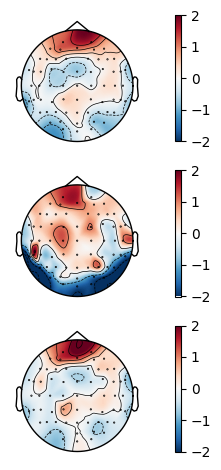

In [4]:
# the mean of all data
test_all_data = np.squeeze(np.mean(data, axis=0))
test_all_data = (test_all_data - np.mean(test_all_data)) / np.std(test_all_data)
# test_all_data = 2*(test_all_data - np.min(test_all_data)) / (np.max(test_all_data) - np.min(test_all_data)) - 1
mean_all_test = np.mean(test_all_data, axis=1)

# the mean of all cam
test_all_cam = np.mean(all_cam, axis=0)
test_all_cam = (test_all_cam - np.mean(test_all_cam)) / np.std(test_all_cam)
# test_all_cam = 2*(test_all_cam - np.min(test_all_cam)) / (np.max(test_all_cam) - np.min(test_all_cam)) - 1
mean_all_cam = np.mean(test_all_cam, axis=1)

# apply cam on the input data
# hyb_all = test_all_data * test_all_cam

hyb_all = np.einsum('b c h w, b h w -> b h w', data, all_cam)
hyb_all = np.mean(hyb_all, axis=0)

hyb_all = (hyb_all - np.mean(hyb_all)) / np.std(hyb_all)
# hyb_all = 2*(hyb_all - np.min(hyb_all)) / (np.max(hyb_all) - np.min(hyb_all)) - 1
mean_hyb_all = np.mean(hyb_all, axis=1)

evoked = mne.EvokedArray(test_all_data, info)
evoked.set_montage(easycapm1_montage)

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3)

# print(mean_all_test)
plt.subplot(311)
im1, cn1 = mne.viz.plot_topomap(mean_all_test, evoked.info, show=False, axes=ax1, res=1200, vlim=(-2, 2))

plt.subplot(312)
im2, cn2 = mne.viz.plot_topomap(mean_all_cam, evoked.info, show=False, axes=ax2, res=1200, vlim=(-2, 2))

plt.subplot(313)
im3, cn3 = mne.viz.plot_topomap(mean_hyb_all, evoked.info, show=False, axes=ax3, res=1200, vlim=(-2, 2))

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.colorbar(im3, ax=ax3)
plt.tight_layout()
plt.savefig('/home/songyonghao/Documents/Code/NICE/pic/cat_sa_sub%d.png' % nSub, dpi=600)
plt.savefig('/home/songyonghao/Documents/Code/NICE/pic/cat_sa_sub%d.svg' % nSub, dpi=600)

In [ ]:
print(max(mean_all_test))
print(max(mean_all_cam))
print(max(mean_hyb_all))
# plt.savefig('/home/songyonghao/Documents/Code/NICE/pic/Conf/cat_sa.png', dpi=600)